In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
self = afm_scanner_logic
from hardware.timetagger_counter import HWRecorderMode

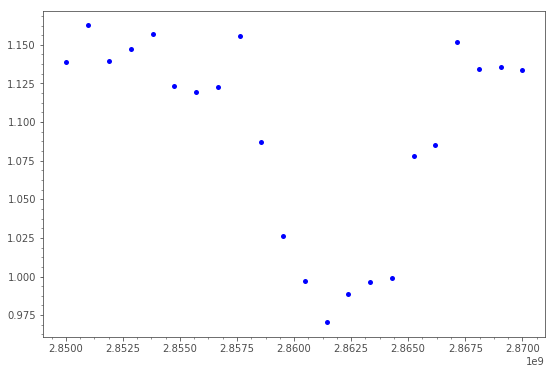

In [9]:
freq_start = 2.85e9
freq_stop = 2.87e9
freq_points = 21
num_runs = 60000
mw_power = -3
pi_half_duration = 250e-9

var_start = freq_start
var_stop = freq_stop
var_incr = round((var_stop-var_start)/freq_points,0)
self.mw_tracking_mode_runs = 1 #for PODMR mode, perform only one measurement per pixel
mw_tracking_mode_runs = self.mw_tracking_mode_runs
alternating = False
laser_pulses = freq_points # is normally not used for mw_list_mode or mw_tracking_mode
bin_width_s = self._podmr.bin_width_s
record_length_s = self._podmr.record_length_s
analysis_settings = self._podmr.pulsed_analysis_settings
analysis_settings['method'] = 'mean_norm'

var_list = np.arange(var_start, var_stop+var_incr, var_incr)

sweep_return = self._podmr.set_AWG_sweep(var_start, var_stop, var_incr, mw_power, pi_half_duration)
mw_start, mw_stop, mw_step, self.sweep_mw_power, mode, freq_points = sweep_return

ret_val = self._counter.configure_recorder(mode= HWRecorderMode.GENERAL_PULSED,params={
    'laser_pulses': freq_points,'bin_width_s': bin_width_s,'record_length_s': record_length_s,'max_counts': int(num_runs-1)} )

self._pulser.load_swabian_sequence(self._make_pulse_sequence(mode = 'PODMR_AWG', pi_half_pulse = pi_half_duration))
self._podmr_seq = self._pulser._seq
self._pulser.load_swabian_sequence(self._make_pulse_sequence('NextTrigger'))
self._next_trigger_seq = self._pulser._seq

self._mw.cw_on_3()

if self._counter.recorder.getHistogramIndex()==-1:
    self._pulser._seq = self._next_trigger_seq
    self._pulser.pulser_on(n=1)
    while True:
        if self._pulser.pulse_streamer.hasFinished():
            break
self._pulser._seq = self._podmr_seq
self._counter.start_recorder(arm=True)

self._podmr._pulsed_master_AWG.pulsedmeasurementlogic().pulsegenerator().pulser_on(trigger=True)

self._pulser.pulser_on(trigger=False, n=int(num_runs*freq_points), final= None)

pulsed_meas = self._counter.get_measurements()[0]

pulsed_ret0, pulsed_ret1 = self.analyse_pulsed_meas(analysis_settings, pulsed_meas, alternating, mw_list_mode, mw_tracking_mode)

self._mw.off()
self._counter.stop_measurement()
self._pulser.pulser_off()

plt.plot(var_list,pulsed_ret0,'bo')
plt.show()

In [5]:
freq_start = 2.85e9
freq_stop = 2.88e9
freq_points = 21
num_runs = 60000
mw_power = -3
pi_half_duration = 250e-9
mw_list_mode = True
mw_tracking_mode = False
n = 1

var_start = freq_start
var_stop = freq_stop
var_incr = round((var_stop-var_start)/freq_points,0)
self.mw_tracking_mode_runs = 1 #for PODMR mode, perform only one measurement per pixel
mw_tracking_mode_runs = self.mw_tracking_mode_runs
alternating = False
laser_pulses = freq_points # is normally not used for mw_list_mode or mw_tracking_mode
bin_width_s = self._podmr.bin_width_s
record_length_s = self._podmr.record_length_s
analysis_settings = self._podmr.pulsed_analysis_settings
analysis_settings['method'] = 'mean_norm'
var_list = np.linspace(var_start, var_stop, freq_points, endpoint=True)

# sweep_return = self._podmr.set_AWG_sweep(var_start, var_stop, var_incr, mw_power, pi_half_duration)



mw_start = freq_start
mw_stop = freq_stop
mw_step = var_incr

sweep_return = self._podmr.set_AWG_sweep(mw_start, mw_stop, mw_step, mw_power, pi_half_duration)
mw_start, mw_stop, mw_step, sweep_mw_power, mode, freq_points = sweep_return

final_freq_list = np.arange(mw_start, mw_stop + mw_step, mw_step)
print(mw_start, mw_stop + mw_step, mw_step)
print(len(final_freq_list), freq_points)
laser_pulses = len(final_freq_list)
err_code = self._podmr._mw_device.cw_on()

mode, is_running = self._podmr._mw_device.get_status()


ret_val = self._podmr._odmr_counter._sc_device.configure_recorder(
                        mode=11, # pulsed mode
                        params={'laser_pulses': laser_pulses,
                                'bin_width_s': bin_width_s,
                                'record_length_s': record_length_s,
                                'max_counts': num_runs-1} )

self._podmr._odmr_counter._sc_device.start_recorder(arm=True)

self._podmr.set_up_next_trigger()

self._podmr._odmr_counter._pulser.pulser_on(n=int(1))
# return

while True:
    time.sleep(0.001)
    if self._podmr._odmr_counter._pulser.pulse_streamer.hasFinished():
        break

self._podmr.set_up_odmr(pi_half_duration)

self._podmr._pulsed_master_AWG.pulsedmeasurementlogic().pulsegenerator().pulser_on(trigger=True)
self._podmr._odmr_counter._pulser.pulser_on(n = num_runs*laser_pulses)

2850000000.0 2881428571.0 1428571.0
23 23


0

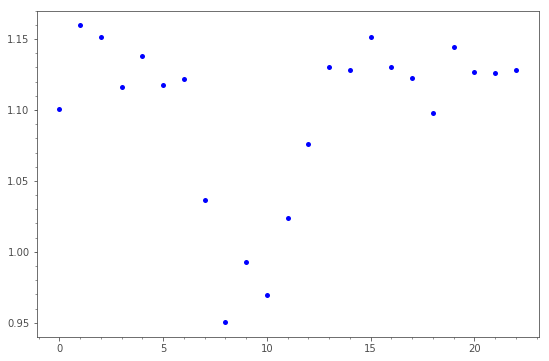

In [6]:
# pulsed_meas = self._counter.get_measurements()[0]

# pulsed_ret0, pulsed_ret1 = self.analyse_pulsed_meas(analysis_settings, pulsed_meas, alternating, mw_list_mode, mw_tracking_mode)

laser_data = self._podmr._odmr_counter._sc_device.get_measurements()[0]
data, err = self._podmr.analyse_pulsed_meas(self._podmr.pulsed_analysis_settings, laser_data)

plt.plot(data,'bo')
plt.show()


In [91]:
self._podmr.mw_off()
self._podmr._stop_odmr_counter()
self._podmr._odmr_counter._pulser.pulser_off()
# self._podmr._pulsed_master_AWG.toggle_pulse_generator(False)

0